# Phase Mask Design

In this notebook we will illustrate the inverse design of a phase mask, choosing the example from [Wong et al., 2021](https://ui.adsabs.harvard.edu/abs/2021JOSAB..38.2465W/abstract): designing a diffractive pupil phase mask for the Toliman telescope.

In order to get high precision centroids, we need to maximise the gradient energy of the pupil; in order to satisfy fabrication constraints, we need a binary mask with phases of only 0 or π.

In [1]:
# Core jax
import jax.numpy as np
import jax.random as jr
from jax import vmap

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

We will first generate an orthonormal basis for the pupil phases, then threshold this to {0, 1} while preserving soft edges using the Continuous Latent-Image Mask Binarization (CLIMB) algorithm from the Wong et al. paper.

Generate basis vectors however you like -- in this case we are using logarithmic radial harmonics and sines/cosines in $\theta$ -- but you can do whatever you want here. This code is not important; just generate your favourite not-necessarily-orthonormal basis, and we will use Principal Component Analysis (PCA) to orthonormalise it later on.

In [2]:
# Define arrays sizes, samplings, symmetries
wf_npix = 256
oversample = 3
nslice = 3

# Define basis hyper parameters
a = 10
b = 8
ith = 10

# Define coordinate grids
npix = wf_npix * oversample
c = (npix - 1) / 2.
xs = (np.arange(npix) - c) / c
XX, YY = np.meshgrid(xs, xs)
RR = np.sqrt(XX ** 2 + YY ** 2)
PHI = np.arctan2(YY, XX)

# Generate basis vectors to map over
As = np.arange(-a, a+1)
Bs = nslice * np.arange(0, b+1)
Cs = np.array([-np.pi/2, np.pi/2])
Is = np.arange(-ith, ith+1)

# Define basis functions
LRHF_fn = lambda A, B, C, RR, PHI: np.cos(A*np.log(RR + 1e-12) + B*PHI + C)
sine_fn = lambda i, RR: np.sin(i * np.pi * RR)
cose_fn = lambda i, RR: np.cos(i * np.pi * RR)

# Map over basis functions
gen_LRHF_basis = vmap(vmap(vmap( \
                            LRHF_fn, (None, 0, None, None, None)), 
                                     (0, None, None, None, None)), 
                                     (None, None, 0, None, None))
gen_sine_basis = vmap(sine_fn, in_axes=(0, None))
gen_cose_basis = vmap(cose_fn, in_axes=(0, None))

# Generate basis
LRHF_basis = gen_LRHF_basis(As, Bs, Cs, RR, PHI) \
            .reshape([len(As)*len(Bs)*len(Cs), npix, npix])
sine_basis = gen_sine_basis(Is, RR)
cose_basis = gen_cose_basis(Is, RR)

# Format shapes and combine
LRHF_flat = LRHF_basis.reshape([len(As)*len(Bs)*len(Cs), npix*npix])
sine_flat = sine_basis.reshape([len(sine_basis), npix*npix])
cose_flat = cose_basis.reshape([len(cose_basis), npix*npix])
full_basis = np.concatenate([
    LRHF_flat,
    sine_flat,
    cose_flat
])

Orthonormalise with PCA -- you could also use Gram-Schmidt if you prefer.

In [3]:
%%time
from sklearn.decomposition import PCA
pca = PCA().fit(full_basis)

components = pca.components_.reshape([len(full_basis), npix, npix])
components = np.copy(components[:99,:,:])
basis = np.concatenate([np.mean(pca.mean_)*np.array(np.ones((1,npix,npix))), components])

# save for use later
np.save('files/basis', basis)

# # Load if already generated
# basis = np.load('files/basis.npy')

CPU times: user 6min 2s, sys: 47.5 s, total: 6min 50s
Wall time: 59.7 s


Visualising the pretty basis vectors:

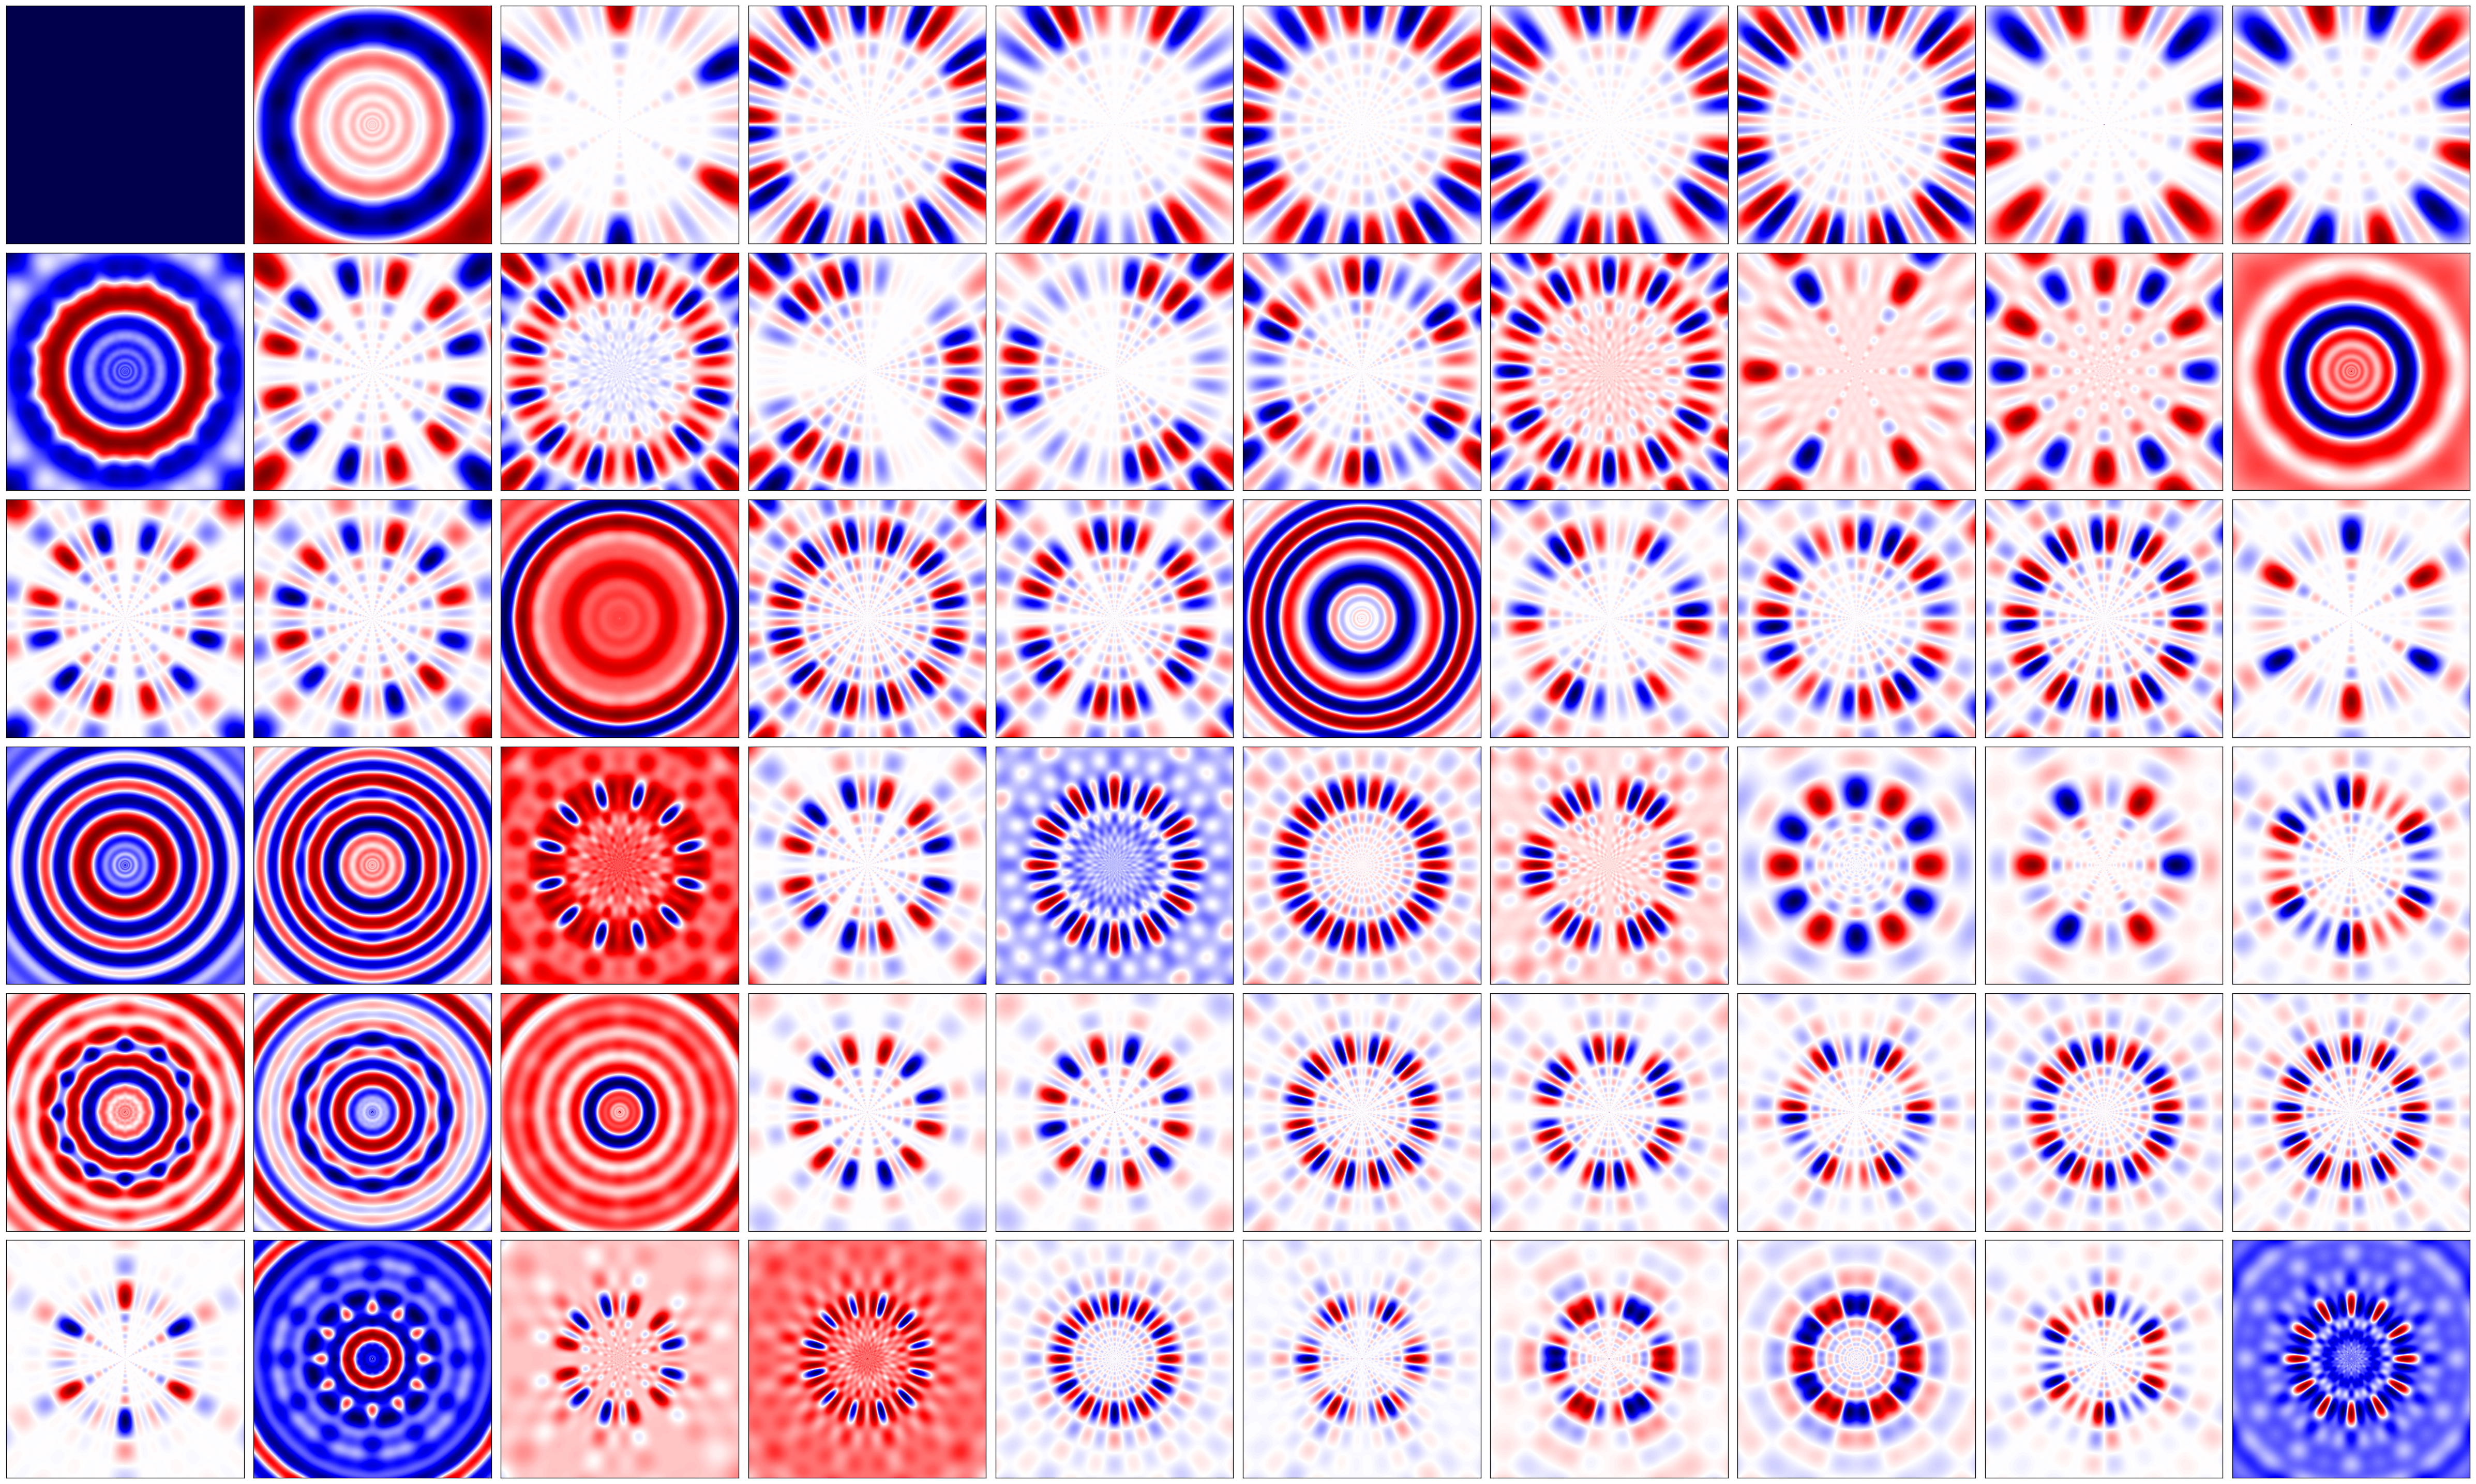

In [4]:
nfigs = 60
ncols = 10
nrows = 1 + nfigs//ncols

plt.figure(figsize=(4*ncols, 4*nrows))
for i in range(nfigs):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(basis[i], cmap='seismic')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

---

## Optimising the Pupil

First we want to construct a ∂Lux layer that we can use to design a binary mask; for this, we will use `ApplyBasisCLIMB` which soft-thresholds the edges (see [Wong et al., 2021](https://ui.adsabs.harvard.edu/abs/2021JOSAB..38.2465W/abstract), sec. 3.2.2). In brief, this creates an optical path difference (OPD) map as a weighted sum of modes; we set it to π phase where it is positive, we set it to zero phase where it is negative, and we soft-edge it on the edges to propagate gradients.

These models reside in the external [`dLuxToliman`](https://github.com/maxecharles/dLuxToliman) package, which you can install with `pip install dLuxToliman`.

In [6]:
from dLuxToliman import TolimanOptics, ApplyBasisCLIMB

# Define our mask layer, here we use ApplyBasisCLIMB
wavels = 1e-9 * np.linspace(595, 695, 3)
coeffs = 100*jr.normal(jr.PRNGKey(0), [len(basis)])
CLIMB = ApplyBasisCLIMB(basis, np.mean(wavels), coeffs)
optics = TolimanOptics(psf_npixels=128, mask=CLIMB)

We also add a small amount of Gaussian jitter to assist in engineering the PSF shape, then define a simple point source. We then combine all of these together into an `Instrument` object.

In [7]:
# Add some detector jitter
detector = dl.LayeredDetector([dl.ApplyJitter(1)])

# Define a source
source = dl.PointSource(wavelengths=wavels)

# Create our instrument
tel = dl.Instrument(optics, source, detector)

We also define a maximum radius which we want light to be confined within. Now, let's examine all this together.

In [8]:
lamd = wavels.max() / optics.diameter
sampling_rate = lamd / optics.true_pixel_scale
rmax = 8*sampling_rate # 8 lam/D

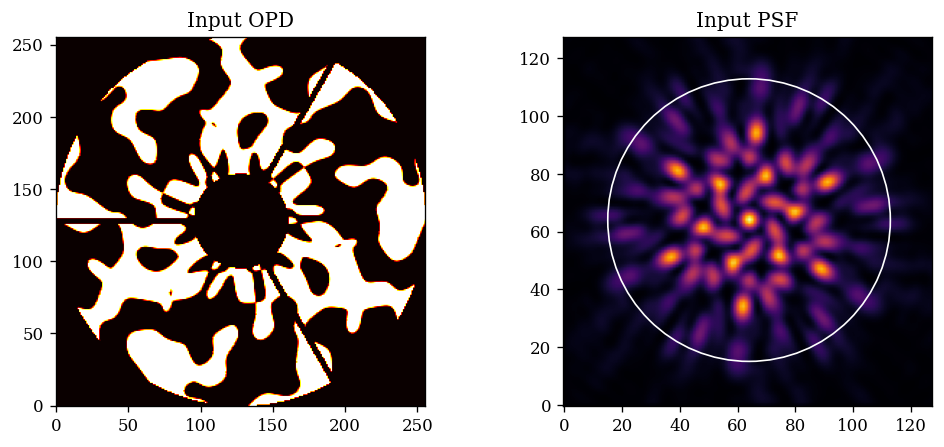

In [9]:
aperture = tel.aperture.transmission
mask = tel.mask.get_binary_phase()
outer = plt.Circle((64, 64), rmax, fill=False, color='w')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture*mask, cmap='hot')
plt.title('Input OPD')

ax = plt.subplot(1, 2, 2)
ax.imshow(tel.model())
ax.set_title('Input PSF')
ax.add_patch(outer)
plt.show()

Now, let's define our loss function. We can pass the string path to our mask coefficients to the `zdx.filter_value_and_grad` function in order to generate gradients for only those terms!

In [10]:
from dLuxToliman import get_radial_mask, get_GE, get_RGE, get_RWGE
param = 'mask.coefficients'

@zdx.filter_jit
@zdx.filter_value_and_grad(param)
def loss_func(tel, rmax=150, power=0.5):
    # Get PSF, Gradients and Mask
    psf = tel.model()

    Rmask = get_radial_mask(psf.shape[0], 0, rmax)

    # Calculate loss
    loss1 = - np.power(Rmask*get_GE(psf),  power).sum()
    loss2 = - np.power(Rmask*get_RGE(psf), power).sum()
    return loss1 + loss2

Evaluate once to `jit` compile:

In [11]:
%%time
loss, grads = loss_func(tel, rmax=rmax) # Compile
print("Initial Loss: {}".format(loss))

Initial Loss: -36.050437927246094
CPU times: user 3.56 s, sys: 119 ms, total: 3.68 s
Wall time: 3.06 s


Gradient descent time!

In [12]:
model = tel
optim, opt_state = zdx.get_optimiser(model, param, optax.adam(8e1))

losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_func(model, rmax=rmax)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)

        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Visualising the results:

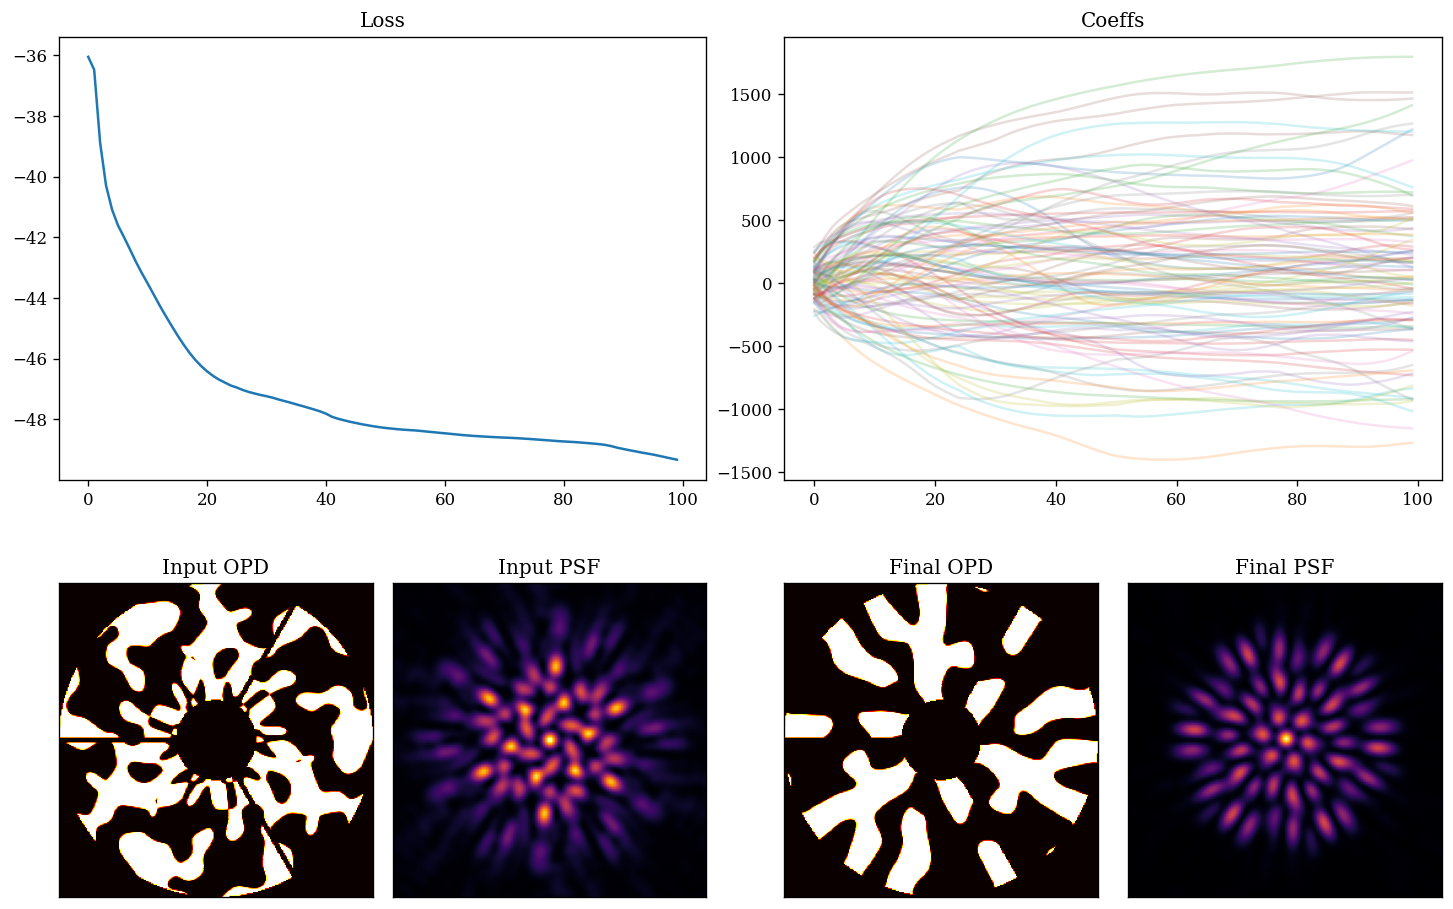

In [13]:
coeffs_out = np.array([model.get(param) for model in models_out])

mosaic = """
         AABB
         CDEF
         """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(losses))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

axes['C'].imshow(aperture*mask,cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = tel.set('detector.layers', {}).model()
axes['D'].imshow(psf_in)
axes['D'].set_title('Input PSF')

final = models_out[-1]
axes['E'].imshow(aperture*final.mask.get_binary_phase(),cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = final.model()
axes['F'].imshow(psf_out)
axes['F'].set_title('Final PSF')
plt.show()

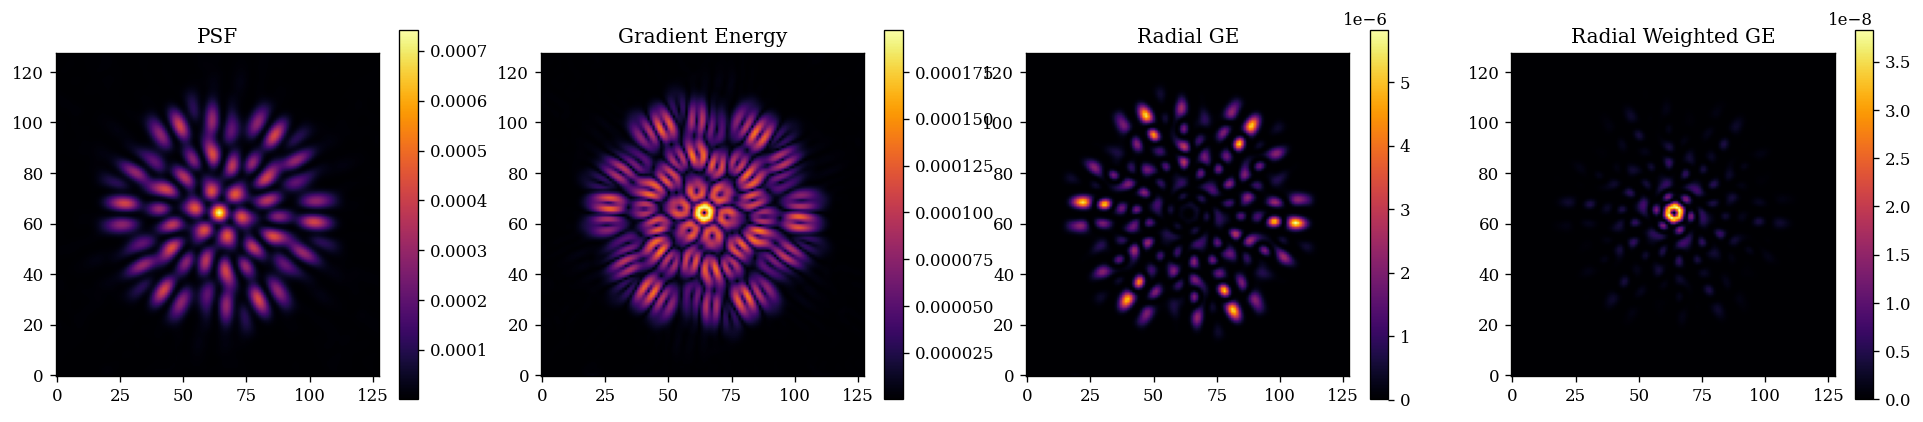

In [14]:
# Visualise GE Metrics
oversample = 2
final_optics = models_out[-1].optics
params = ['psf_pixel_scale', 'psf_npixels']
oversampled = final_optics.multiply(params, [1/oversample, oversample*npix])
oversampled_psf = final_optics.model(source)

# Plot
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title("PSF")
plt.imshow(psf_out)
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title("Gradient Energy")
plt.imshow(get_GE(psf_out))
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title("Radial GE")
plt.imshow(get_RGE(psf_out))
plt.colorbar()

plt.subplot(1, 4, 4)
plt.title("Radial Weighted GE")
plt.imshow(get_RWGE(psf_out))
plt.colorbar()
plt.show()

In [17]:
# Save mask for use in flatfield_calibration notebook
mask_out = models_out[-1].mask.get_binary_phase()
np.save("files/test_mask", mask_out)